<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/notebooks/sensitivity/SensitivityAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Based on the original sensitivity analysis notebook at
# https://github.com/nitrogenlab/GP15_watermassanalysis/blob/5d0420ae4b8a4689a8cee98e36876e8ed2cb8c68/GP15analysis_sensitivityanalysis.ipynb

#Install pyompa
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/


%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1272, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (384/384), done.
remote: Total 1272 (delta 410), reused 341 (delta 193), pack-reused 692
Receiving objects: 100% (1272/1272), 14.92 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (896/896), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 96a9520fe0cf7ecad24b1d2ba69952d473ecfe26 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Dec 8 15:56:32 2021 -0800

    rolled back change
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can f

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [2]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 97 (delta 52), reused 65 (delta 25), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit d7d1c8a2143b6f656e3001be7096a7dcf3fd763a (HEAD -> main, origin/main, origin/HEAD)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Sun Dec 5 20:03:02 2021 -0600

    removed redundant code, updated settings
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/

<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [3]:
gp15_df, gp15_intermediateanddeep, gp15_thermocline = gp15wma.download_and_load_gp15_data(
    station_to_tc_cutoffs_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json")

bottle flag BTLNBR_FLAG_W BTLNBR_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
CTD salinity flag CTDSAL_FLAG_W CTDSAL_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
bottle oxygen flag Flag_OXYGEN_D_CONC_BOTTLE_qizf9x Flag_OXYGEN_D_CONC_BOTTLE_n41f8b
uint8
leg1 nans 0
leg2 nans 0
silicate flag Flag_SILICATE_D_CONC_BOTTLE_l9fh07 Flag_SILICATE_D_CONC_BOTTLE_3fot83
uint8
leg1 nans 0
leg2 nans 0
nitrate flag Flag_NITRATE_D_CONC_BOTTLE_xhgtuv Flag_NITRATE_D_CONC_BOTTLE_bugat8
uint8
leg1 nans 0
leg2 nans 0
phosphate flag Flag_PHOSPHATE_D_CONC_BOTTLE_lof4ap Flag_PHOSPHATE_D_CONC_BOTTLE_d0rgav
uint8
leg1 nans 0
leg2 nans 0
CTD pressure CTDPRS CTDPRS
float64
leg1 nans 487
leg2 nans 492
CTD temperature CTDTMP CTDTMP
float64
leg1 nans 487
leg2 nans 492
practical_salinity CTDSAL CTDSAL
float64
leg1 nans 487
leg2 nans 492
lat LATITUDE LATITUDE
float64
leg1 nans 476
leg2 nans 484
lon LONGITUDE LONGITUDE
float64
leg1 nans 476
leg2 nans 484
stnnbr STNNBR STNNBR
<U12
leg1 and leg2 arrays are strings.
geotrc_ID GEOTRC_SAMP

In [4]:
interanddeep_endmember_df = gp15wma.load_interanddeep_endmember_df(
    df_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv",
    df_file_name="GP15_intermediateanddeep.csv")


In [5]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments
import numpy as np
import json

#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = gp15wma.settingdefaults.PARAM_WEIGHTINGS

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

intermediate_and_deep_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": gp15_intermediateanddeep,
          "endmembername_to_usagepenaltyfunc": gp15wma.settingdefaults.USAGE_PENALTY,
          "param_names": gp15wma.settingdefaults.PARAM_NAMES,
          "convertedparam_groups": gp15wma.settingdefaults.CONVERTEDPARAM_GROUPS
          },
        solve_arguments={
            "endmember_df": interanddeep_endmember_df,
            "endmember_name_column": "watermass_name",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = intermediate_and_deep_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":[
         "lat", "lon", "Depth", "stnnbr", "geotrc_ID"]})

On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'conservative_temp': 50.526633616124734, 'absolute_salinity': 67.46596781384733, 'silicate': 3.3314168678086586, 'nitrate': 5.564955985200404, 'phosphate': 5.523207828614988, 'oxygen': 1.1657612453077295, 'NO': 1.063449112776969, 'PO': 0.5136735163145865}}, solve_arguments={})
Adding penalty for ENPCW_0
Adding penalty for ENPCW_1
Adding penalty for SPCW_0
Adding penalty for SPCW_1
Adding penalty for PSUW_0
Adding penalty for PSUW_1
Adding penalty for ESSW_0
Adding penalty for ESSW_1
Adding penalty for EqIW_0
Adding penalty for EqIW_1
Adding penalty for LCDW_0
Adding penalty for LCDW_1
Adding penalty for AAIW_0
Adding penalty for AAIW_1
Adding penalty for NPIW_0
Adding penalty for NPIW_1
Adding penalty for NPIW_2
Adding penalty for UCDW_0
Adding penalty for AABW_0
Endmember-idx mapping is
 OrderedDict([('AABW', [0]), ('AAIW', [1, 2]), ('ENPCW', [3, 4]), ('ESSW', [5, 6]), ('EqIW',

In [6]:
from gp15wma.sensitivity import get_mean_and_stdev_skeletons

mean_skeleton, std_skeleton = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

mean


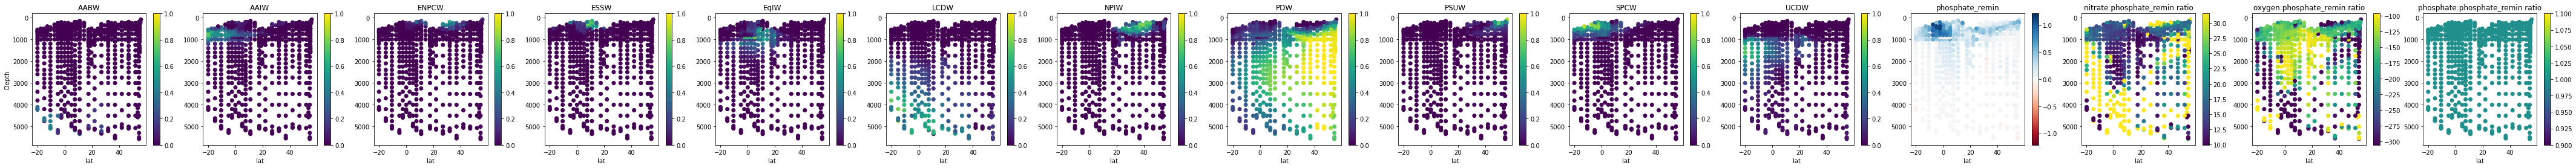

std


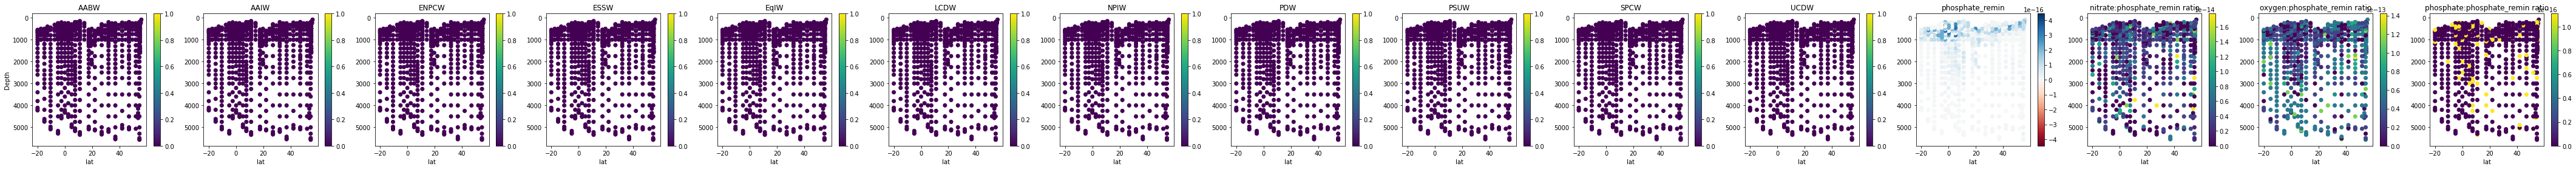

In [7]:
#plot the solutions
print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth",
                                  group_endmembers=True)
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth",
                                  group_endmembers=True)


mean


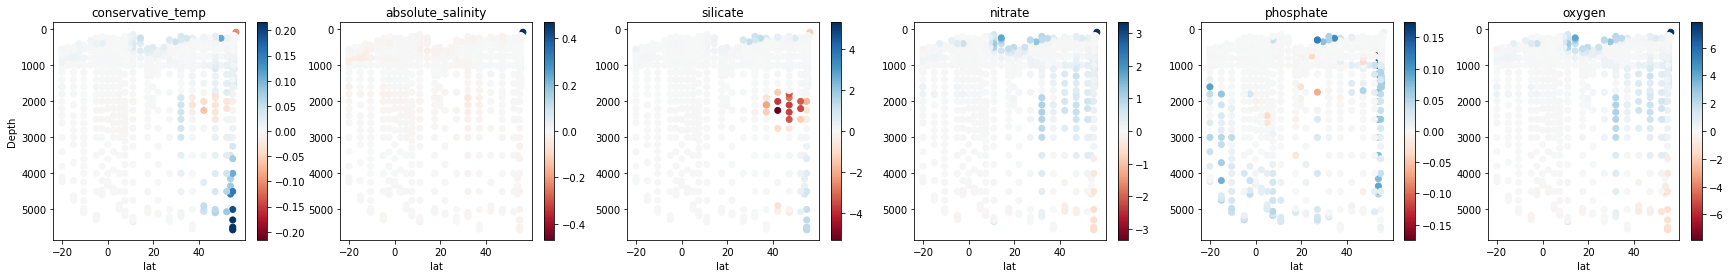

std


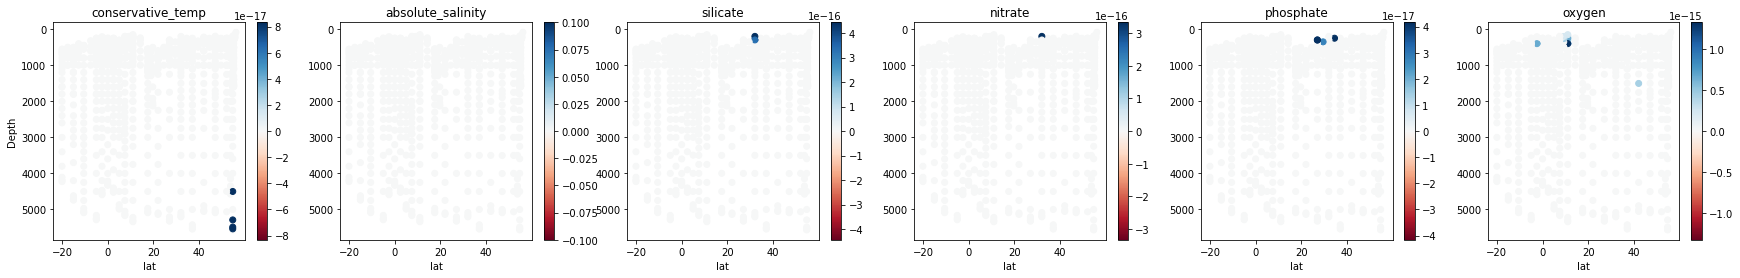

In [8]:
print("mean")
pyompa.plot_ompasoln_residuals(ompa_soln=mean_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")
print("std")
pyompa.plot_ompasoln_residuals(ompa_soln=std_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")

In [11]:
###uncomment below to export csv with senstivity analysis info###

#ORIG_COLS_TO_INCLUDE = ["lat", "lon", "Depth", "CTD pressure", "stnnbr", "geotrc_ID", "sigma0"]
#mean_skeleton.export_to_csv(
    #csv_output_name="mean_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
#std_skeleton.export_to_csv(
    #csv_output_name="std_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

writing to mean_skeleton.csv
writing to std_skeleton.csv
